In [405]:
#### 1. 라이브러리 import

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
#!pip install tensorflow
#!pip install xgboost
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

In [407]:
#### 2. data 불러오기  및 데이터전처리 
path='C:/Users/user/Desktop/선지/대학원/2학기/기특/제주_re/이게최종일듯'


## 기후 data
wd1=pd.read_csv(path+'/'+'2021_기후.csv', header =0 ,encoding='cp949', index_col=False) 
wd2=pd.read_csv(path+'/'+'2022_기후.csv', header =0 ,encoding='cp949', index_col=False) 
wd3=pd.read_csv(path+'/'+'2023_기후.csv', header =0 ,encoding='cp949', index_col=False) 
wd4=pd.read_csv(path+'/'+'2024_기후.csv', header =0 ,encoding='cp949', index_col=False) 

# "지점명" 컬럼 삭제
wd1_n = wd1.drop(columns=['지점명','운형(운형약어)'])
wd2_n = wd2.drop(columns=['지점명','운형(운형약어)'])
wd3_n = wd3.drop(columns=['지점명','운형(운형약어)'])
wd4_n = wd4.drop(columns=['지점명','운형(운형약어)'])

# 일시와 지점명으로 그룹화하고 평균 계산
wd1_m = wd1_n.groupby(['일시']).mean().reset_index()
wd2_m = wd2_n.groupby(['일시']).mean().reset_index()
wd3_m = wd3_n.groupby(['일시']).mean().reset_index()
wd4_m = wd4_n.groupby(['일시']).mean().reset_index()

# 기후최종 
wd4_cb = pd.concat([wd1_m, wd2_m, wd3_m,wd4_m], ignore_index=True)

# 'date1'이 2021-01 ~ 2023-12인 데이터만 선택
wd4_cb_n = wd4_cb[(wd4_cb['일시'] >= '2021-01-01 00:00') & (wd4_cb['일시'] <= '2023-12-31 23:00')]



## 태양광 및 풍속 발전량 data
sp_1=pd.read_csv(path+'/'+'제주지역 태양광 한시간단위실적(2019-12-01_2023-12-31).csv', header =0 ,encoding='cp949', index_col=False) 
wp_1=pd.read_csv(path+'/'+'제주지역 풍력 한시간단위실적(2019-12-01_2023-12-31).csv', header =0 ,encoding='cp949', index_col=False) 

# 태양광 date 데이터로 변환 
sp_1_melted = sp_1.melt(id_vars=['날짜'], var_name='시간', value_name='태양열발전량')

for hour in range(1, 25):
    old_time = f"{hour}시"  # '01시', '02시', ..., '24시' 형식
    new_time = f"{hour:02d}:00"  # '01:00', '02:00', ..., '24:00' 형식
    sp_1_melted['시간'][sp_1_melted['시간'] == old_time] = new_time

sp_1_melted.loc[sp_1_melted['시간'] == '24:00', '시간'] = '00:00'
sp_1_melted['date']=sp_1_melted['날짜']+' '+sp_1_melted['시간']
sp_1_n = sp_1_melted[['date','태양열발전량']]

# 풍력발전량 date 데이터로 변환 
wp_1_melted = wp_1.melt(id_vars=['날짜'], var_name='시간', value_name='풍력발전량')

for hour in range(1, 25):
    old_time = f"{hour}시"  # '01시', '02시', ..., '24시' 형식
    new_time = f"{hour:02d}:00"  # '01:00', '02:00', ..., '24:00' 형식
    wp_1_melted['시간'][wp_1_melted['시간'] == old_time] = new_time

wp_1_melted.loc[wp_1_melted['시간'] == '24:00', '시간'] = '00:00'
wp_1_melted['date']=wp_1_melted['날짜']+' '+wp_1_melted['시간']
wp_1_n = wp_1_melted[['date','풍력발전량']]

# 풍력발전 + 태양력발전 
ws_1_n=pd.merge(wp_1_n,sp_1_n,left_on='date',right_on='date',how='left')

## 설비용량 data
ps_1=pd.read_csv(path+'/'+'HOME_전력거래_시장참여설비용량(전력시장·PPA)_연료원별.csv', header =0 ,encoding='cp949', index_col=False) 
ps_1 = ps_1.drop(columns=['지역'])
ps_1.rename(columns={'기간':'date1', '태양':'태양설비용량','풍력':'풍력설비용량'},inplace=True)

## 발전량 data & 설비용량 data merge
wp_1_n['date1'] = wp_1_n['date'].str[:7]  # 'YYYY-MM' 형식으로 잘라내기
sp_1_n['date1'] = sp_1_n['date'].str[:7]  # 'YYYY-MM' 형식으로 잘라내기
ws_1_n['date1'] = ws_1_n['date'].str[:7]  # 'YYYY-MM' 형식으로 잘라내기

merg_wp=pd.merge(wp_1_n,ps_1,left_on='date1',right_on='date1',how='left')
merg_sp=pd.merge(sp_1_n,ps_1,left_on='date1',right_on='date1',how='left')
merg_wsp=pd.merge(ws_1_n,ps_1,left_on='date1',right_on='date1',how='left')

# 2021-01 ~ 2023-12인 데이터만 선택
merg_wp_n = merg_wp[(merg_wp['date1'] >= '2021-01') & (merg_wp['date1'] <= '2023-12')]
merg_sp_n = merg_sp[(merg_sp['date1'] >= '2021-01') & (merg_sp['date1'] <= '2023-12')]
merg_wsp_n = merg_wsp[(merg_wsp['date1'] >= '2021-01') & (merg_wsp['date1'] <= '2023-12')]
wd4_cb_n = wd4_cb[(wd4_cb['일시'] >= '2021-01-01 00:00') & (wd4_cb['일시'] <= '2023-12-31 23:00')]


### 최종분석데이터 merge
merg_wp_l=pd.merge(wd4_cb_n, merg_wp_n,left_on='일시',right_on='date',how='left')
merg_sp_l=pd.merge(wd4_cb_n,merg_sp_n,left_on='일시',right_on='date',how='left')
merg_wsp_l=pd.merge(wd4_cb_n,merg_wsp_n,left_on='일시',right_on='date',how='left')

### 예측데이터 전처리
merg_wsp_l['총발전량']=merg_wsp_l['풍력발전량']+merg_wsp_l['태양열발전량']


C:\Users\user\AppData\Local\Temp\ipykernel_8840\897652906.py:41: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sp_1_melted['시간'][sp_1_melted['시간'] == old_time] = new_time
C:\Users\user\AppData\Local\Temp\ipykernel_8840\897652906.py:41: Setti

In [409]:
#### 3. 상관성 분석
## 총발전량과 기후요소 상관성 분석 
# date 열을 제외한 데이터프레임 생성
df_without_date = merg_wsp_l.drop(columns=['일시','date1','date'])

# 상관계수 계산
correlation_matrix = df_without_date.corr()

# 결과 출력
print(correlation_matrix['총발전량'].sort_values())



# 최종분석 기후변수 정리 
wsp_last=merg_wsp_l[['일시','지면온도(°C)','기온(°C)','풍속(m/s)','일사(MJ/m2)','일조(hr)','습도(%)','중하층운량(10분위)','풍향(16방위)','총발전량']]

지면온도 QC플래그      -0.552473
습도(%)           -0.394913
적설(cm)          -0.177895
이슬점온도(°C)       -0.158948
20cm 지중온도(°C)   -0.147167
30cm 지중온도(°C)   -0.138439
증기압(hPa)        -0.132471
10cm 지중온도(°C)   -0.123232
5cm 지중온도(°C)    -0.108804
최저운고(100m )     -0.087465
전운량(10분위)       -0.064360
중하층운량(10분위)     -0.029681
기온(°C)          -0.029152
현상번호(국내식)       -0.023640
강수량(mm)          0.002589
풍력설비용량           0.012250
일조 QC플래그         0.014478
일사 QC플래그         0.015079
전력시장 계           0.036937
태양설비용량           0.040124
3시간신적설(cm)       0.069356
해면기압(hPa)        0.077793
현지기압(hPa)        0.078051
시정(10m)          0.121198
풍향(16방위)         0.174127
지면온도(°C)         0.189169
일조(hr)           0.549823
풍력발전량            0.551342
풍속(m/s)          0.621870
일사(MJ/m2)        0.667688
태양열발전량           0.736393
총발전량             1.000000
지점                    NaN
기온 QC플래그              NaN
강수량 QC플래그             NaN
풍속 QC플래그              NaN
풍향 QC플래그              NaN
습도 QC플래그              NaN
현지기압 QC플래그  

In [411]:
#### 4. 결측값 대체  
# 날짜시간 형식 변환
wsp_last['일시'] = pd.to_datetime(wsp_last['일시'])
wsp_last.set_index('일시', inplace=True)


# 결측치 처리 방법 1: 평균으로 대체하기
wsp_last[['일사(MJ/m2)', '일조(hr)']].fillna(0, inplace=True)
wsp_last.fillna(wsp_last.mean(), inplace=True)

# 결측치 확인
print(wsp_last.isna().sum())


지면온도(°C)       0
기온(°C)         0
풍속(m/s)        0
일사(MJ/m2)      0
일조(hr)         0
습도(%)          0
중하층운량(10분위)    0
풍향(16방위)       0
총발전량           0
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_8840\1143557628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsp_last['일시'] = pd.to_datetime(wsp_last['일시'])
C:\Users\user\AppData\Local\Temp\ipykernel_8840\1143557628.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsp_last[['일사(MJ/m2)', '일조(hr)']].fillna(0, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_8840\1143557628.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

### 모델링1. 논문 동일조건(LSTM)

Training Data Shape: (13980, 24, 8) (13980,)
Validation Data Shape: (3494, 24, 8) (3494,)
Test Data Shape: (8712, 24, 8) (8712,)
Epoch 1/300


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0280 - val_loss: 0.0173
Epoch 2/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0174 - val_loss: 0.0144
Epoch 3/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0153 - val_loss: 0.0121
Epoch 4/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0134 - val_loss: 0.0103
Epoch 5/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0111 - val_loss: 0.0099
Epoch 6/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0096 - val_loss: 0.0080
Epoch 7/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0087 - val_loss: 0.0071
Epoch 8/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 9/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 10/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 11/300
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 12/300
437/437 ━━━━━━━━━━

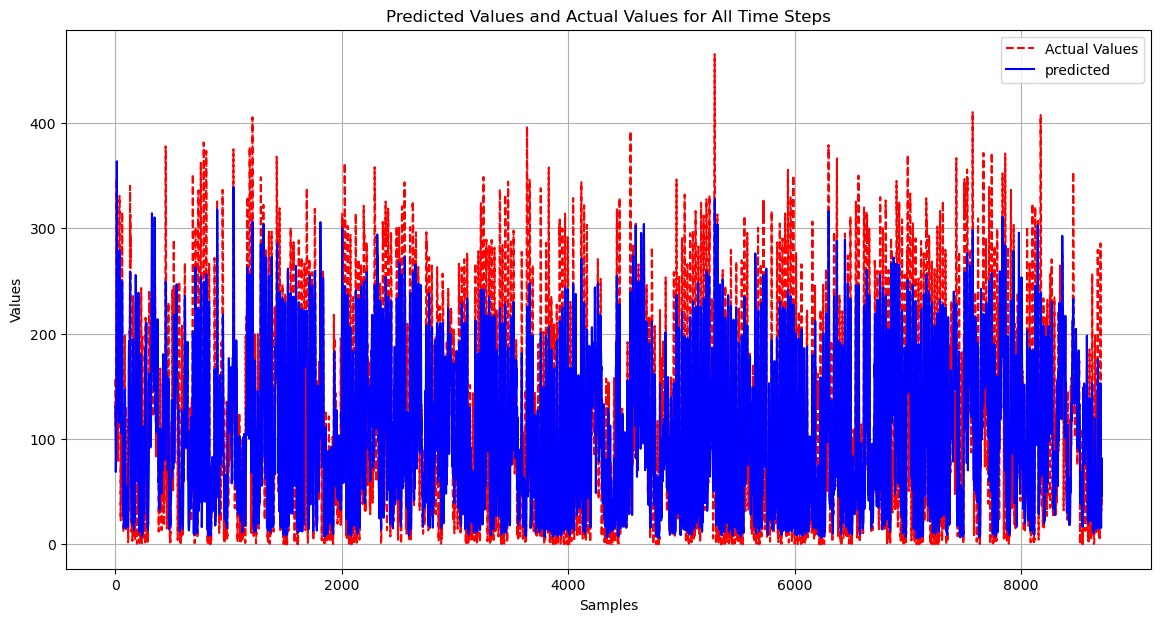

In [415]:
### 5. 모델링(총발전량 예측) _  논문과 동일 하이퍼파라미터 설정  _ 논문과 유사성능 확인완료 (LSTM : 38.81MWh)
# 논문상 Hyper Parameters : layer = 7, time_step=24, epochs=300, Dropout(0.3), units=64 
# 평균절대오차(MAE): 35.07025779463377 MWh 

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(wsp_last)

# 시계열 데이터 생성 함수
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :8]  # 8번째 열 제외
        X.append(a)
        Y.append(dataset[i + time_step, 8])  # 예측할 미래 값
    return np.array(X), np.array(Y)

# Sequence Length (Time Step) 변경
time_step = 24
X, y = create_dataset(scaled_data, time_step)

# 2021~2022년 데이터의 인덱스를 계산하여 train_size 설정
train_indices = np.arange(len(wsp_last))
train_years = wsp_last.index.year
train_size = len(wsp_last[(train_years >= 2021) & (train_years <= 2022)])

X_train, y_train = X[:train_size], y[:train_size]

# 검증 데이터 설정 (5의 배수 인덱스)
validation_indices = [i for i in range(train_size) if (i + 1) % 5 == 0]
X_val = X_train[validation_indices]
y_val = y_train[validation_indices]

# 훈련 데이터에서 검증 데이터 제거
X_train = np.delete(X_train, validation_indices, axis=0)
y_train = np.delete(y_train, validation_indices, axis=0)

# 2023년 데이터는 테스트 데이터로 사용
X_test, y_test = X[train_size:], y[train_size:]

# 결과 확인
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)


# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(units=64, return_sequences=True))  # 두 번째 LSTM 레이어
model.add(Dropout(0.3))

model.add(LSTM(units=64, return_sequences=True))  # 세 번째 LSTM 레이어
model.add(Dropout(0.3))

model.add(LSTM(units=64, return_sequences=True))  # 네 번째 LSTM 레이어
model.add(Dropout(0.3))

model.add(LSTM(units=64, return_sequences=True))  # 다섯 번째 LSTM 레이어
model.add(Dropout(0.3))

model.add(LSTM(units=64, return_sequences=True))  # 여섯 번째 LSTM 레이어
model.add(Dropout(0.3))

model.add(LSTM(units=64))  # 일곱 번째 LSTM 레이어 (return_sequences=False)
model.add(Dropout(0.3))

model.add(Dense(1))  # 출력층



# 모델 컴파일 (학습률 0.001)
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 설정
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 예측
predicted1 = model.predict(X_test)
# 예측 결과의 shape 확인
print(f"predicted1 shape: {predicted1.shape}")

# 역스케일링
# X_test의 마지막 타임스텝을 가져오고, predicted와 결합
last_timesteps1 = X_test[:, -1, :].reshape(X_test.shape[0], X_test.shape[2])  # 2D로 변환

# 예측
predicted1 = model.predict(X_test)

# 예측 결과의 shape 확인
print(f"predicted1 shape: {predicted1.shape}")  # 예측 결과의 shape 확인

# 역스케일링
last_timesteps1 = X_test[:, -1, :].reshape(X_test.shape[0], X_test.shape[2])  # 2D로 변환

# predicted1에서 마지막 예측값만 사용 (predicted1은 2차원)
predicted1_last = predicted1  # (N, 1) 형태

# 역스케일링
predicted_inverse1 = scaler.inverse_transform(np.concatenate((last_timesteps1, predicted1_last), axis=1))[:, -1]
y_test_inverse1 = scaler.inverse_transform(np.concatenate((last_timesteps1, y_test.reshape(-1, 1)), axis=1))[:, -1]

# MAE 계산
mae1 = np.mean(np.abs(predicted_inverse1 - y_test_inverse1))
print(f"평균절대오차(MAE): {mae1} MWh")

# 모든 타임스텝의 예측값 시각화
import matplotlib.pyplot as plt

# 모든 타임스텝의 예측값 시각화
plt.figure(figsize=(14, 7))

# 실제값 시각화
plt.plot(y_test_inverse1, label='Actual Values', color='red', linestyle='--')
plt.plot(predicted_inverse1 , label='predicted', color='blue')

plt.title('Predicted Values and Actual Values for All Time Steps')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

### 모델링2. 논문 디벨롭 _LSTM  Hyper Parameters 조정

In [464]:
### 5. 모델링(총발전량 예측) _  논문디벨롭 _ 하이퍼파라미터 설정변경  _ 평균절대오차(MAE): 32.09667022026356 MWh
##  Hyper Parameters 조정 : layer = 2, time_step=12, epochs=150, Dropout(0.3), units=32 

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(wsp_last)

# 시계열 데이터 생성 함수
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :8]  # 8번째 열 제외
        X.append(a)
        Y.append(dataset[i + time_step, 8])  # 예측할 미래 값
    return np.array(X), np.array(Y)

# Sequence Length (Time Step) 변경
time_step = 12
X, y = create_dataset(scaled_data, time_step)

# 2021~2022년 데이터의 인덱스를 계산하여 train_size 설정
train_indices = np.arange(len(wsp_last))
train_years = wsp_last.index.year
train_size = len(wsp_last[(train_years >= 2021) & (train_years <= 2022)])

X_train, y_train = X[:train_size], y[:train_size]

# 검증 데이터 설정 (5의 배수 인덱스)
validation_indices = [i for i in range(train_size) if (i + 1) % 5 == 0]
X_val = X_train[validation_indices]
y_val = y_train[validation_indices]

# 훈련 데이터에서 검증 데이터 제거
X_train = np.delete(X_train, validation_indices, axis=0)
y_train = np.delete(y_train, validation_indices, axis=0)

# 2023년 데이터는 테스트 데이터로 사용
X_test, y_test = X[train_size:], y[train_size:]

# 결과 확인
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)


# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=32))  # LSTM 기본 활성화 함수
model.add(Dropout(0.3))
model.add(Dense(1))  # 출력층에 ReLU 활성화 함수 적용


# 모델 컴파일 (학습률 0.001)
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 설정
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 예측
predicted1 = model.predict(X_test)
# 예측 결과의 shape 확인
print(f"predicted1 shape: {predicted1.shape}")

# 역스케일링
# X_test의 마지막 타임스텝을 가져오고, predicted와 결합
last_timesteps1 = X_test[:, -1, :].reshape(X_test.shape[0], X_test.shape[2])  # 2D로 변환

# 예측
predicted1 = model.predict(X_test)

# 예측 결과의 shape 확인
print(f"predicted1 shape: {predicted1.shape}")  # 예측 결과의 shape 확인

# 역스케일링
last_timesteps1 = X_test[:, -1, :].reshape(X_test.shape[0], X_test.shape[2])  # 2D로 변환

# predicted1에서 마지막 예측값만 사용 (predicted1은 2차원)
predicted1_last = predicted1  # (N, 1) 형태

# 역스케일링
predicted_inverse1 = scaler.inverse_transform(np.concatenate((last_timesteps1, predicted1_last), axis=1))[:, -1]
y_test_inverse1 = scaler.inverse_transform(np.concatenate((last_timesteps1, y_test.reshape(-1, 1)), axis=1))[:, -1]

# MAE 계산
mae1 = np.mean(np.abs(predicted_inverse1 - y_test_inverse1))
print(f"평균절대오차(MAE): {mae1} MWh")

# 모든 타임스텝의 예측값 시각화
import matplotlib.pyplot as plt

# 모든 타임스텝의 예측값 시각화
plt.figure(figsize=(14, 7))

# 실제값 시각화
plt.plot(y_test_inverse1, label='Actual Values', color='red', linestyle='--')
plt.plot(predicted_inverse1 , label='predicted', color='blue')

plt.title('Predicted Values and Actual Values for All Time Steps')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

Training Data Shape: (13980, 12, 8) (13980,)
Validation Data Shape: (3494, 12, 8) (3494,)
Test Data Shape: (8724, 12, 8) (8724,)


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Input 0 of layer "lstm_187" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)

### 모델링3. 논문 디벨롭2_lstm + xgboost 앙상블 

Training Data Shape: (13980, 12, 8) (13980,)
Validation Data Shape: (3494, 12, 8) (3494,)
Test Data Shape: (8724, 12, 8) (8724,)
Epoch 1/150


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0282 - val_loss: 0.0105
Epoch 2/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0127 - val_loss: 0.0086
Epoch 3/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0090
Epoch 4/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0099 - val_loss: 0.0075
Epoch 5/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0072
Epoch 6/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 7/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 8/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 9/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 10/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 11/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 12/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

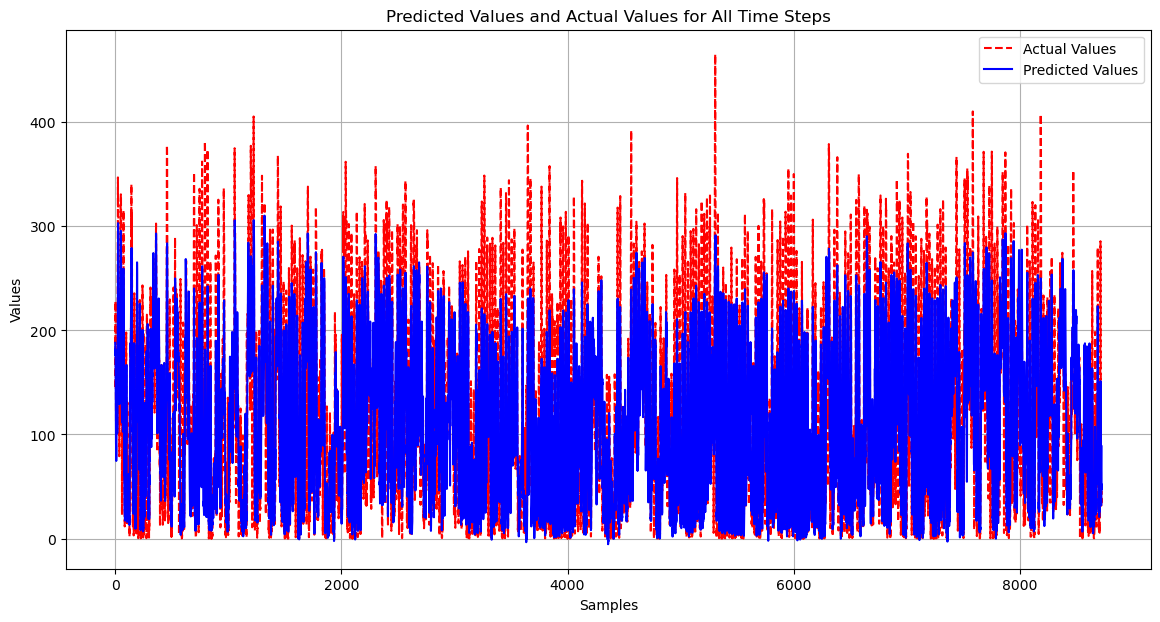

In [462]:
## 평균절대오차(MAE): 32.16474369536956 MWh

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(wsp_last)

# 시계열 데이터 생성 함수
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :8]
        X.append(a)
        Y.append(dataset[i + time_step, 8])  # 예측할 미래 값
    return np.array(X), np.array(Y)

# 시퀀스 길이 설정
time_step = 12
X, y = create_dataset(scaled_data, time_step)


# 2021~2022년 데이터의 인덱스를 계산하여 train_size 설정
train_indices = np.arange(len(wsp_last))
train_years = wsp_last.index.year
train_size = len(wsp_last[(train_years >= 2021) & (train_years <= 2022)])

X_train, y_train = X[:train_size], y[:train_size]

# 검증 데이터 설정 (5의 배수 인덱스)
validation_indices = [i for i in range(train_size) if (i + 1) % 5 == 0]
X_val = X_train[validation_indices]
y_val = y_train[validation_indices]

# 훈련 데이터에서 검증 데이터 제거
X_train = np.delete(X_train, validation_indices, axis=0)
y_train = np.delete(y_train, validation_indices, axis=0)

# 2023년 데이터는 테스트 데이터로 사용
X_test, y_test = X[train_size:], y[train_size:]

# 결과 확인
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(1))  # 출력층

# 모델 컴파일
optimizer = 'adam'
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# LSTM 예측
lstm_predicted = model.predict(X_test)

# XGBoost 모델 학습을 위한 데이터 준비
# LSTM의 예측 결과를 XGBoost의 입력으로 사용
X_train_xgb = np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1)
X_val_xgb = np.concatenate((X_val[:, -1, :], y_val.reshape(-1, 1)), axis=1)
X_test_xgb = np.concatenate((X_test[:, -1, :], lstm_predicted), axis=1)

# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_xgb, y_train)

# XGBoost 예측
xgb_predicted = xgb_model.predict(X_test_xgb)

# 앙상블 예측 (LSTM과 XGBoost의 평균)
final_predicted = (lstm_predicted.flatten() + xgb_predicted) / 2

# 역스케일링
last_timesteps = X_test[:, -1, :].reshape(X_test.shape[0], X_test.shape[2])  # 2D로 변환
predicted_last = final_predicted.reshape(-1, 1)  # (N, 1) 형태
predicted_inverse = scaler.inverse_transform(np.concatenate((last_timesteps, predicted_last), axis=1))[:, -1]
y_test_inverse = scaler.inverse_transform(np.concatenate((last_timesteps, y_test.reshape(-1, 1)), axis=1))[:, -1]

# MAE 계산
mae = np.mean(np.abs(predicted_inverse - y_test_inverse))
print(f"평균절대오차(MAE): {mae} MWh")

# 모든 타임스텝의 예측값 시각화
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Values', color='red', linestyle='--')
plt.plot(predicted_inverse, label='Predicted Values', color='blue')
plt.title('Predicted Values and Actual Values for All Time Steps')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()


### 모델링4. 논문 디벨롭2_lstm + Bagging 앙상블

Training Data Shape: (13980, 12, 8) (13980,)
Validation Data Shape: (3494, 12, 8) (3494,)
Test Data Shape: (8724, 12, 8) (8724,)
Epoch 1/150


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0256 - val_loss: 0.0101
Epoch 2/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0086
Epoch 3/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0080
Epoch 4/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0074
Epoch 5/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0071
Epoch 6/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 7/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0065
Epoch 8/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0073
Epoch 9/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 10/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 11/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 12/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

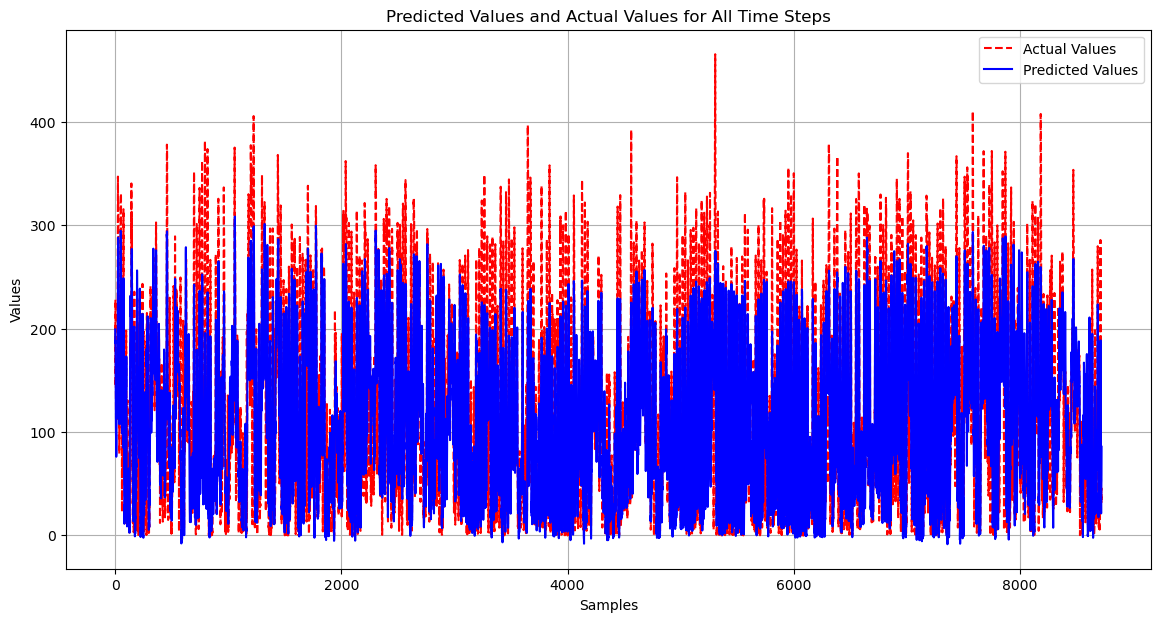

In [470]:
# 평균절대오차(MAE): 31.431894624987955 MWh (현재 이게 best)

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(wsp_last)

# 시계열 데이터 생성 함수
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :8]
        X.append(a)
        Y.append(dataset[i + time_step, 8])  # 예측할 미래 값
    return np.array(X), np.array(Y)

# 시퀀스 길이 설정
time_step = 12
X, y = create_dataset(scaled_data, time_step)

# 2021~2022년 데이터의 인덱스를 계산하여 train_size 설정
train_indices = np.arange(len(wsp_last))
train_years = wsp_last.index.year
train_size = len(wsp_last[(train_years >= 2021) & (train_years <= 2022)])

X_train, y_train = X[:train_size], y[:train_size]

# 검증 데이터 설정 (5의 배수 인덱스)
validation_indices = [i for i in range(train_size) if (i + 1) % 5 == 0]
X_val = X_train[validation_indices]
y_val = y_train[validation_indices]

# 훈련 데이터에서 검증 데이터 제거
X_train = np.delete(X_train, validation_indices, axis=0)
y_train = np.delete(y_train, validation_indices, axis=0)

# 2023년 데이터는 테스트 데이터로 사용
X_test, y_test = X[train_size:], y[train_size:]

# 결과 확인
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(1))  # 출력층

# 모델 컴파일
optimizer = 'adam'
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# LSTM 예측
lstm_predicted = model.predict(X_test)

# Bagging 모델 학습을 위한 데이터 준비
# LSTM의 예측 결과를 Bagging의 입력으로 사용
X_train_bagging = np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1)
X_val_bagging = np.concatenate((X_val[:, -1, :], y_val.reshape(-1, 1)), axis=1)
X_test_bagging = np.concatenate((X_test[:, -1, :], lstm_predicted), axis=1)

# Bagging 모델 학습
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_model.fit(X_train_bagging, y_train)

# Bagging 예측
bagging_predicted = bagging_model.predict(X_test_bagging)

# 앙상블 예측 (LSTM과 Bagging의 평균)
final_predicted = (lstm_predicted.flatten() + bagging_predicted) / 2

# 역스케일링
last_timesteps = X_test[:, -1, :].reshape(X_test.shape[0], X_test.shape[2])  # 2D로 변환
predicted_last = final_predicted.reshape(-1, 1)  # (N, 1) 형태
predicted_inverse = scaler.inverse_transform(np.concatenate((last_timesteps, predicted_last), axis=1))[:, -1]
y_test_inverse = scaler.inverse_transform(np.concatenate((last_timesteps, y_test.reshape(-1, 1)), axis=1))[:, -1]

# MAE 계산
mae = np.mean(np.abs(predicted_inverse - y_test_inverse))
print(f"평균절대오차(MAE): {mae} MWh")

# 모든 타임스텝의 예측값 시각화
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Values', color='red', linestyle='--')
plt.plot(predicted_inverse, label='Predicted Values', color='blue')
plt.title('Predicted Values and Actual Values for All Time Steps')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()


### 모델링5. 논문 디벨롭2_lstm + Stacking 앙상블

Training Data Shape: (13980, 12, 8) (13980,)
Validation Data Shape: (3494, 12, 8) (3494,)
Test Data Shape: (8724, 12, 8) (8724,)
Epoch 1/150


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0268 - val_loss: 0.0108
Epoch 2/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0088
Epoch 3/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0082
Epoch 4/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 5/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 6/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 7/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_loss: 0.0071
Epoch 8/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 9/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 10/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 11/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 12/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

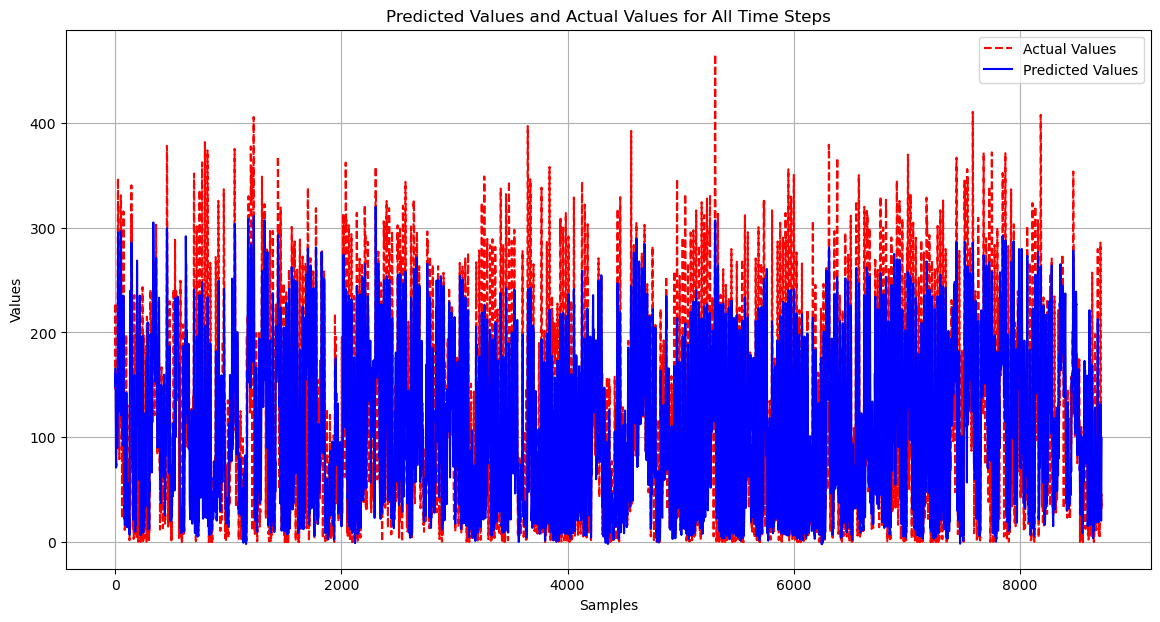

In [478]:
# 평균절대오차(MAE): 32.115056955356216 MWh

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(wsp_last)

# 시계열 데이터 생성 함수
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :8]
        X.append(a)
        Y.append(dataset[i + time_step, 8])  # 예측할 미래 값
    return np.array(X), np.array(Y)

# 시퀀스 길이 설정
time_step = 12
X, y = create_dataset(scaled_data, time_step)

# 2021~2022년 데이터의 인덱스를 계산하여 train_size 설정
train_indices = np.arange(len(wsp_last))
train_years = wsp_last.index.year
train_size = len(wsp_last[(train_years >= 2021) & (train_years <= 2022)])

X_train, y_train = X[:train_size], y[:train_size]

# 검증 데이터 설정 (5의 배수 인덱스)
validation_indices = [i for i in range(train_size) if (i + 1) % 5 == 0]
X_val = X_train[validation_indices]
y_val = y_train[validation_indices]

# 훈련 데이터에서 검증 데이터 제거
X_train = np.delete(X_train, validation_indices, axis=0)
y_train = np.delete(y_train, validation_indices, axis=0)

# 2023년 데이터는 테스트 데이터로 사용
X_test, y_test = X[train_size:], y[train_size:]

# 결과 확인
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(1))  # 출력층

# 모델 컴파일
optimizer = 'adam'
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# LSTM 예측
lstm_predicted = model.predict(X_test)

# Stacking 모델 학습을 위한 데이터 준비
# LSTM의 예측 결과를 Stacking의 입력으로 사용
X_train_stacking = np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1)
X_val_stacking = np.concatenate((X_val[:, -1, :], y_val.reshape(-1, 1)), axis=1)
X_test_stacking = np.concatenate((X_test[:, -1, :], lstm_predicted), axis=1)

# Stacking 모델 학습
base_models = [
    ('dt', DecisionTreeRegressor()),
    # 다른 기본 모델을 추가할 수 있습니다.
]

stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression(), cv=5)
stacking_model.fit(X_train_stacking, y_train)

# Stacking 예측
stacking_predicted = stacking_model.predict(X_test_stacking)

# 앙상블 예측 (LSTM과 Stacking의 평균)
final_predicted = (lstm_predicted.flatten() + stacking_predicted) / 2

# 역스케일링
last_timesteps = X_test[:, -1, :].reshape(X_test.shape[0], X_test.shape[2])  # 2D로 변환
predicted_last = final_predicted.reshape(-1, 1)  # (N, 1) 형태
predicted_inverse = scaler.inverse_transform(np.concatenate((last_timesteps, predicted_last), axis=1))[:, -1]
y_test_inverse = scaler.inverse_transform(np.concatenate((last_timesteps, y_test.reshape(-1, 1)), axis=1))[:, -1]

# MAE 계산
mae = np.mean(np.abs(predicted_inverse - y_test_inverse))
print(f"평균절대오차(MAE): {mae} MWh")

# 모든 타임스텝의 예측값 시각화
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Values', color='red', linestyle='--')
plt.plot(predicted_inverse, label='Predicted Values', color='blue')
plt.title('Predicted Values and Actual Values for All Time Steps')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()


### 모델링6. 논문 디벨롭2_lstm + Voting 앙상블

Training Data Shape: (13980, 12, 8) (13980,)
Validation Data Shape: (3494, 12, 8) (3494,)
Test Data Shape: (8724, 12, 8) (8724,)
Epoch 1/150


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0290 - val_loss: 0.0124
Epoch 2/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0136 - val_loss: 0.0091
Epoch 3/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0111 - val_loss: 0.0085
Epoch 4/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0078
Epoch 5/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - val_loss: 0.0075
Epoch 6/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0073
Epoch 7/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 8/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0084 - val_loss: 0.0069
Epoch 9/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 10/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 11/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 12/150
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

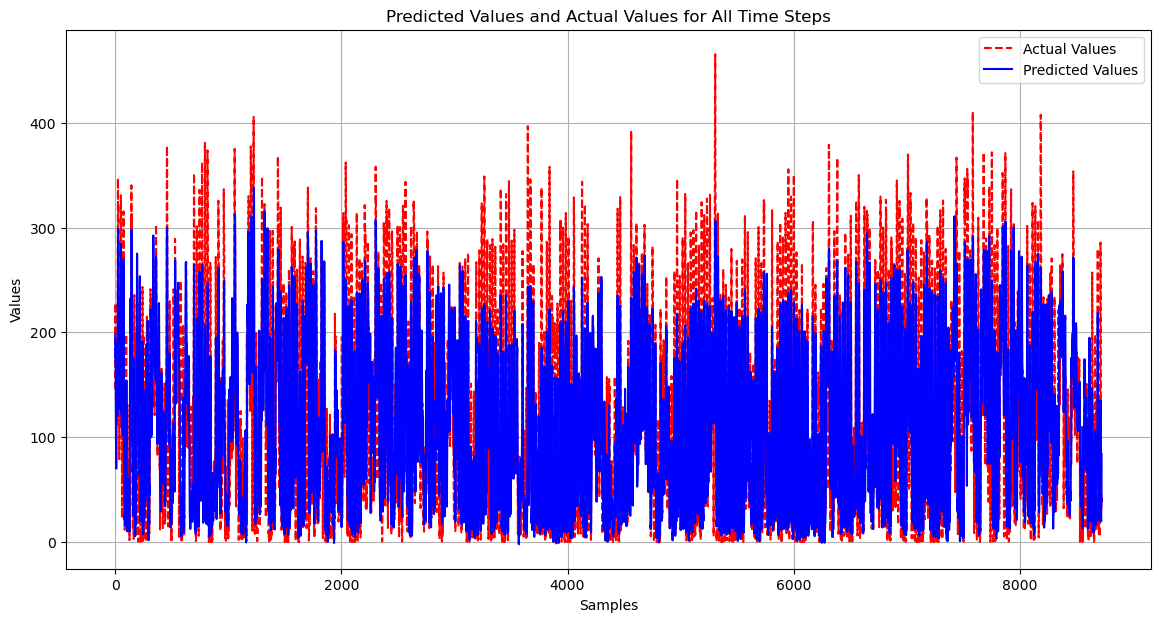

In [483]:
# 평균절대오차(MAE): 32.15014895209528 MWh

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(wsp_last)

# 시계열 데이터 생성 함수
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :8]
        X.append(a)
        Y.append(dataset[i + time_step, 8])  # 예측할 미래 값
    return np.array(X), np.array(Y)

# 시퀀스 길이 설정
time_step = 12
X, y = create_dataset(scaled_data, time_step)

# 2021~2022년 데이터의 인덱스를 계산하여 train_size 설정
train_indices = np.arange(len(wsp_last))
train_years = wsp_last.index.year
train_size = len(wsp_last[(train_years >= 2021) & (train_years <= 2022)])

X_train, y_train = X[:train_size], y[:train_size]

# 검증 데이터 설정 (5의 배수 인덱스)
validation_indices = [i for i in range(train_size) if (i + 1) % 5 == 0]
X_val = X_train[validation_indices]
y_val = y_train[validation_indices]

# 훈련 데이터에서 검증 데이터 제거
X_train = np.delete(X_train, validation_indices, axis=0)
y_train = np.delete(y_train, validation_indices, axis=0)

# 2023년 데이터는 테스트 데이터로 사용
X_test, y_test = X[train_size:], y[train_size:]

# 결과 확인
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(1))  # 출력층

# 모델 컴파일
optimizer = 'adam'
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# LSTM 예측
lstm_predicted = model.predict(X_test)

# Voting 모델 학습을 위한 데이터 준비
# LSTM의 예측 결과를 Voting의 입력으로 사용
X_train_voting = np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1)
X_val_voting = np.concatenate((X_val[:, -1, :], y_val.reshape(-1, 1)), axis=1)
X_test_voting = np.concatenate((X_test[:, -1, :], lstm_predicted), axis=1)

# Voting 모델 학습
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# 기본 모델 설정
base_models = [
    ('dt', DecisionTreeRegressor()),
    ('lr', LinearRegression()),
    # 다른 기본 모델을 추가할 수 있습니다.
]

voting_model = VotingRegressor(estimators=base_models)
voting_model.fit(X_train_voting, y_train)

# Voting 예측
voting_predicted = voting_model.predict(X_test_voting)

# 앙상블 예측 (LSTM과 Voting의 평균)
final_predicted = (lstm_predicted.flatten() + voting_predicted) / 2

# 역스케일링
last_timesteps = X_test[:, -1, :].reshape(X_test.shape[0], X_test.shape[2])  # 2D로 변환
predicted_last = final_predicted.reshape(-1, 1)  # (N, 1) 형태
predicted_inverse = scaler.inverse_transform(np.concatenate((last_timesteps, predicted_last), axis=1))[:, -1]
y_test_inverse = scaler.inverse_transform(np.concatenate((last_timesteps, y_test.reshape(-1, 1)), axis=1))[:, -1]

# MAE 계산
mae = np.mean(np.abs(predicted_inverse - y_test_inverse))
print(f"평균절대오차(MAE): {mae} MWh")

# 모든 타임스텝의 예측값 시각화
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Values', color='red', linestyle='--')
plt.plot(predicted_inverse, label='Predicted Values', color='blue')
plt.title('Predicted Values and Actual Values for All Time Steps')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()
